In [ ]:
#| default_exp viz

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
import cv2
import numpy as np
import kornia

from kornia.utils import tensor_to_image, image_to_tensor
from typing import List, Union, Tuple, Optional
from copy import deepcopy

import matplotlib.pyplot as plt
import torch.nn as nn
from torch import allclose
from typing import Union



In [ ]:
from kornia_moons.feature import (
    to_numpy_image,
    to_torch,
    to_np,
    laf_from_opencv_kpts,
    opencv_kpts_from_laf,
    laf_from_opencv_ORB_kpts,
    cv2_matches_from_kornia,
    laf_from_opencv_SIFT_kpts)

In [ ]:
#| export

def visualize_LAF(img, LAF, img_idx = 0, color='r', linewidth=1,
                  draw_ori = True, fig=None,
                  ax = None, return_fig_ax = False, **kwargs):
    from kornia_moons.feature import to_numpy_image
    x, y = kornia.feature.laf.get_laf_pts_to_draw(kornia.feature.laf.scale_laf(LAF, 0.5), img_idx)
    if not draw_ori:
        x= x[1:]
        y= y[1:]
    if (fig is None and ax is None):
        fig, ax = plt.subplots(1,1, **kwargs)
    if (fig is not None and ax is None):
        ax = fig.add_axes([0, 0, 1, 1])
    
    ax.imshow(to_numpy_image(img[img_idx]))
    ax.plot(x, y, color, linewidth=linewidth)
    if return_fig_ax : return fig, ax
    return


Let's detect ORB keypoints and convert them to and from OpenCV

<matplotlib.image.AxesImage>

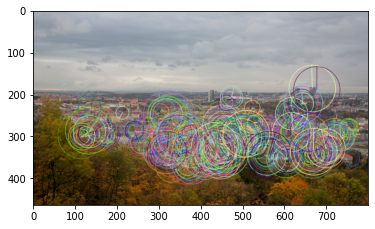

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

<Figure size 432x288 with 0 Axes>

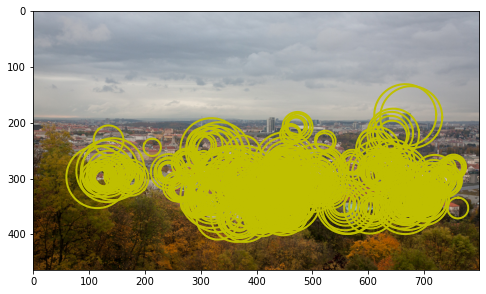

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)
lafs, r = laf_from_opencv_kpts(kps, 1.0, with_resp=True)
fig=plt.figure()
visualize_LAF(image_to_tensor(img, False), lafs, 0, 'y', draw_ori=False,figsize=(8,6), linewidth=2)

<matplotlib.image.AxesImage>

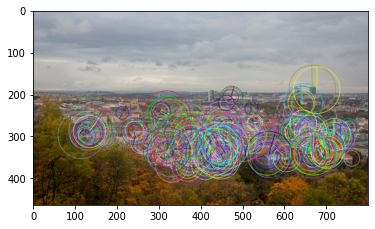

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)
lafs, r = laf_from_opencv_kpts(kps, 1.0, with_resp=True)
kps_back = opencv_kpts_from_laf(lafs, 1.0, r)
out_img = cv2.drawKeypoints(img, kps_back, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

OpenCV uses different conventions for the local feature scale. 

E.g. to get equivalent kornia LAF from ORB keypoints, one should you mrSize = 0.5, 
while for SIFT -- 6.0. The orientation convention is also different for kornia and OpenCV.

In [ ]:
#| export 
def epilines_to_start_end_points(epi, h, w):
    num = len(epi)
    zeros = torch.zeros(num)
    ones = torch.ones(num)
    eps = 1e-8

    
    b = -epi[:,2] / (epi[:,1] + eps)
    k = -epi[:,0] / (epi[:,1] + eps)
    k_positive = k >= 0
    k_negative = k < 0
    
    
    # We find the points of crossing x = 0, x = w, y = 0, y = h
    p1 = torch.stack([zeros,  b], axis=-1)
    p2 = torch.stack([w*ones, k*w + b], axis =-1)
    p3 = torch.stack([-b/(k + eps), zeros], axis=-1)
    p4 = torch.stack([(h - b)/(k + eps), ones*h], axis=-1)
    
    # Now we select those, which are inside of image
    p1_is_start = (p1[:, 1:2] <= h) & (p1[:, 1:2] >= 0)
    p3_is_start = (k_positive * (~p1_is_start.view(-1))).view(-1,1)
    p4_is_start = (k_negative * (~p1_is_start.view(-1))).view(-1,1)
    none_is_start = ~(p1_is_start | p3_is_start |  p4_is_start)
    
    
    p2_is_fin  = (p2[:, 1:2] <= h) & (p2[:, 1:2] >= 0)
    p4_is_fin  = (k_positive * (~p2_is_fin.view(-1))).view(-1,1)
    p3_is_fin  = (k_negative * (~p2_is_fin.view(-1))).view(-1,1)
    
    
    start_lines = p1 * p1_is_start.float() + p3 * p3_is_start.float() + p4 * p4_is_start.float()
    fin_lines   = p2 * p2_is_fin.float()   + p4 * p4_is_fin.float() + p3 * p3_is_fin.float()
    return torch.stack ([start_lines, fin_lines])

In [ ]:
#| export
import kornia as K
import kornia.feature as KF
import torch

def draw_LAF_matches(lafs1, lafs2, tent_idxs,  
                     img1, img2, inlier_mask = None, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                                  "vertical": False}, 
                        Fm: Optional[np.array] = None, H: Optional[np.array] = None,
                        fig = None, ax: Optional = None,
                        return_fig_ax=False):
    '''This function draws LAFs, tentative matches, inliers epipolar lines (if F is provided),
    and image1 corners reprojection into image 2 (if H is provided)'''
    if inlier_mask is not None:
        inlier_mask = np.array(inlier_mask).reshape(-1)
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)
    
    h,w = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    corners_pts = np.float32([[0, 0],
                              [0, h-1],
                              [w-1, h-1],
                              [w-1, 0],
                              [0, 0] ]).reshape(-1,1,2)
        
    
    img2_tr = deepcopy(img2)
    
    xy1 = KF.get_laf_center(to_torch(lafs1)).reshape(-1, 2)
    xy2 = KF.get_laf_center(to_torch(lafs2)).reshape(-1, 2)
    # If we have no axes, create one
    if (fig is None and ax is None):
        fig, ax = plt.subplots(1,1, figsize=(20,10))
    if (fig is not None and ax is None):
        ax = fig.add_axes([0, 0, 1, 1])

    tent_cv2 = cv2_matches_from_kornia(torch.ones(len(tent_idxs)), tent_idxs)
    tent_corrs = torch.stack([xy1[tent_idxs[:,0]], xy2[tent_idxs[:,1]]])
    try:
        vert = draw_dict['vertical']
    except:
        vert = False
    if vert:
        tent_corrs[1,:,1]+=h # shift for the 2nd image
    else:
        tent_corrs[1,:,0]+=w # shift for the 2nd image
    if H is not None:
        dst_corners = cv2.perspectiveTransform(corners_pts, H)
        if vert:
            dst_corners[...,1]+=h
        else:
            dst_corners[...,0]+=w
    # Prepraring canvas
    if not vert:
        if len(img1.shape) == 3:
            new_shape = (max(h, h2), w + w2, img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (max(h, h2), w + w2)
    else:
        if len(img1.shape) == 3:
            new_shape = (h + h2,  max(w, w2), img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (h + h2,  max(w, w2))        
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    if not vert:
        new_img[0:h, 0:w] = img1
        new_img[0:h2, w:w + w2] = img2
    else:
        new_img[0:h, 0:w] = img1
        new_img[h:h+h2, 0:w2] = img2

    x1, y1 = to_np(KF.laf.get_laf_pts_to_draw(lafs1, 0))
    x2, y2 = to_np(KF.laf.get_laf_pts_to_draw(lafs2, 0))
    if vert:
        y2+=h
    else:
        x2+=w
    # Drawing features
    try:
        fc = draw_dict['feature_color']
    except:
        fc = None
    if fc is not None:
        ax.plot(x1, y1, color=fc)
        ax.plot(x2, y2, color=fc)
        
    #Drawgin tentatives
    try:
        tc = draw_dict['tentative_color']
    except:
        tc = None
    if tc is not None:
        ax.plot(tent_corrs[...,0], tent_corrs[...,1], color=tc)
        ax.plot(x1[:, tent_idxs[:,0]], y1[:, tent_idxs[:,0]], color=tc)
        ax.plot(x2[:, tent_idxs[:,1]], y2[:, tent_idxs[:,1]], color=tc)
    try:
        ic = draw_dict['inlier_color']
    except:
        ic = None
    if (ic is not None) and (inlier_mask is not None):
        inlier_mask = inlier_mask > 0
        ax.plot(tent_corrs[..., inlier_mask, 0], tent_corrs[...,inlier_mask, 1], color=ic)
        ax.plot(x1[:, tent_idxs[inlier_mask,0]], y1[:, tent_idxs[inlier_mask,0]], color=ic)
        ax.plot(x2[:, tent_idxs[inlier_mask,1]], y2[:, tent_idxs[inlier_mask,1]], color=ic)
    if H is not None:
        ax.plot(corners_pts[:,0,0], corners_pts[:,0,1], color=(0,0,1))
        ax.plot(dst_corners[:,0,0], dst_corners[:,0,1], color=(0,0,1))
    if (Fm is not None):
        if inlier_mask is None:
            inlier_mask = [True for i in range(len(tent_idxs))]
        tent_corrs2 = torch.stack([xy1[tent_idxs[:,0]], xy2[tent_idxs[:,1]]])
        inl1 = tent_corrs2[0, inlier_mask]
        inl2 = tent_corrs2[1, inlier_mask]
        Ff = torch.from_numpy(Fm).float()
        epi1 = K.geometry.compute_correspond_epilines(inl2.reshape(1,-1, 2), Ff.t()[None])[0]
        epiline1 = epilines_to_start_end_points(epi1, h, w)
        
        epi2 = K.geometry.compute_correspond_epilines(inl1.reshape(1,-1, 2), Ff[None])[0]
        epiline2 = epilines_to_start_end_points(epi2, h2, w2)
        if vert:
            epiline2[...,1]+=h # shift for the 2nd image
        else:
            epiline2[...,0]+=w # shift for the 2nd image            
        
        ax.plot(epiline1[:,:,0], epiline1[:,:,1], color='purple')
        ax.plot(epiline2[:,:,0], epiline2[:,:,1], color='purple')
    # Finally clip the image
    ax.imshow(new_img)
    if not vert:
        ax.set_xlim([0,w+w2])
        ax.set_ylim([max(h,h2),0])
        ax.margins(0,0)
    else:
        ax.set_xlim([0,max(w,w2)])
        ax.set_ylim([h+h2, 0])
        ax.margins(0,0)
    if return_fig_ax : return fig, ax
    return 

We will visualize ORB features (blue), tentative matches (yellow) and inliers(greenish)

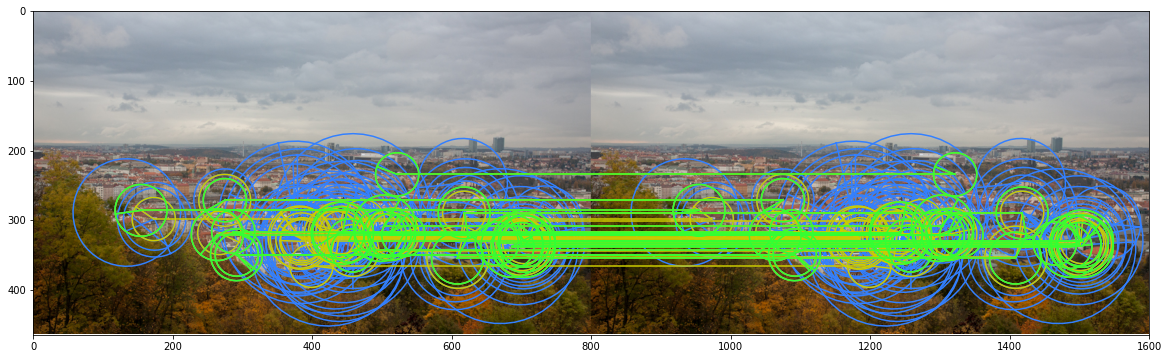

In [ ]:
import numpy as np
det = cv2.ORB_create(100)
img1_fname = 'data/strahov.png'
kps1, descs1 = det.detectAndCompute(cv2.imread(img1_fname,0), None)
lafs1 = laf_from_opencv_ORB_kpts(kps1)
idxs = torch.stack([torch.arange(50),torch.arange(50)], dim=-1)
fig, ax = draw_LAF_matches(lafs1, lafs1, idxs,
                  img1_fname,img1_fname, 
                  [True if i%2 == 0 else False for i in range(len(idxs))],
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                              "vertical": False}, return_fig_ax=True)

Now let's try with epipolar matrix for the translation. Inliers should lie on the horizontal epipolar lines

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


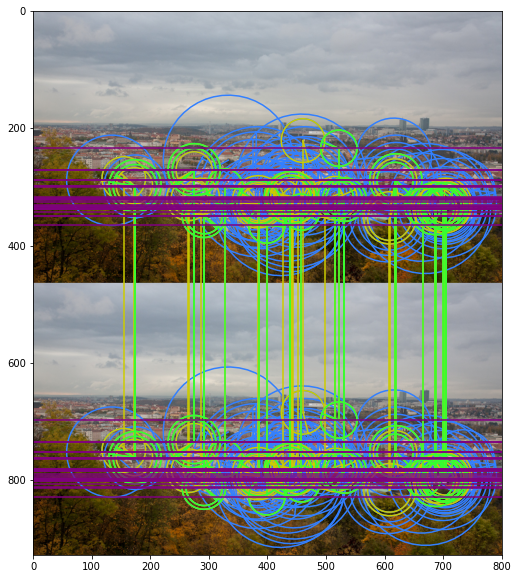

In [ ]:
Fmat = np.array([[0., 0., 0.],
                 [0, 0, -1],
                [0, 1, 0]])
draw_LAF_matches(lafs1, lafs1, idxs,
                  img1_fname,img1_fname, 
                  [True if i%2 == 0 else False for i in range(len(idxs))],
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                              "vertical": True}, Fm = Fmat)

Now we will transform the image, match it, find the homography and visualize it.

libpng warning: iCCP: known incorrect sRGB profile


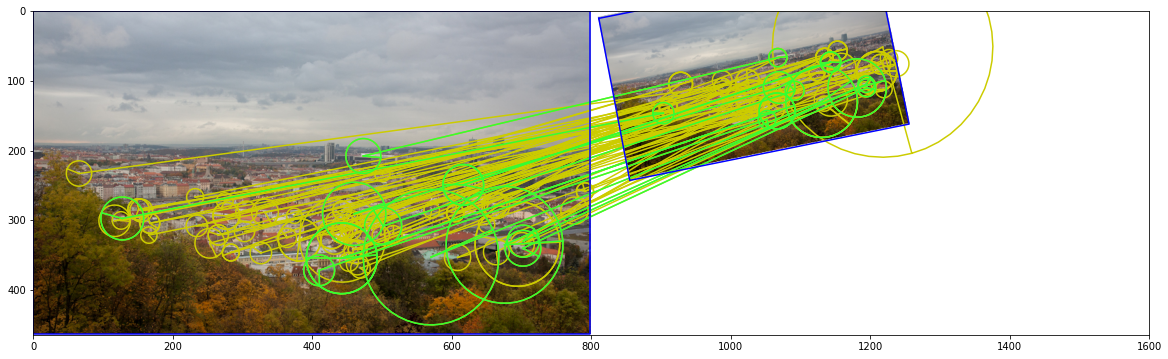

In [ ]:
import numpy as np
det = cv2.SIFT_create(100)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.5, 0.1, 10],
                [-0.1, 0.5, 10],
               [0, 0, 1]])
img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))



kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)


match_dists, match_idxs = kornia.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.98)

H, mask = cv2.findHomography(kornia.feature.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             kornia.feature.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_matches(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask,
                  draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": None,
                              "vertical": False}, H = H)

And the same with fundamental matrix

libpng warning: iCCP: known incorrect sRGB profile


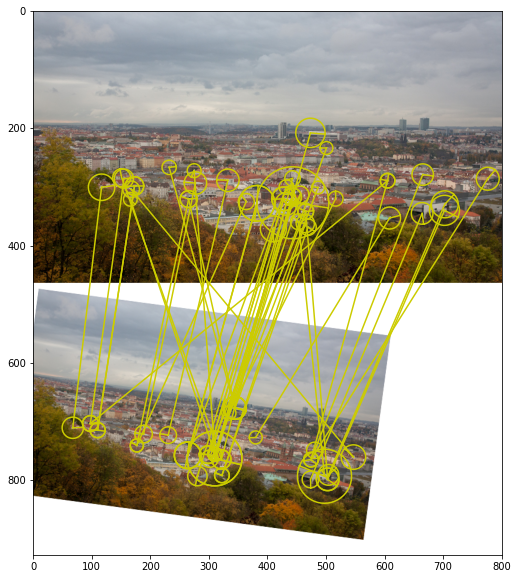

In [ ]:
import numpy as np
det = cv2.SIFT_create(75)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.75, -0.1, 10],
                [0.1, 0.75, 10],
               [0, 0, 1]])

img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))


kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)



match_dists, match_idxs = kornia.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.95)

Fmat, mask = cv2.findFundamentalMat(kornia.feature.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             kornia.feature.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_matches(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask,
                  draw_dict={"inlier_color": None,#(0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": None,
                              "vertical": True})

In [ ]:
#| export
def draw_LAF_matches_from_result_dict(result_dict,
                        img1, img2, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                                  "vertical": False}):
    if 'H' in result_dict:
        H = result_dict['H']
    else:
        H = None
    if 'F' in rbesult_dict:
        Fm = result_dict['F']
    else:
        Fm = None
    return draw_LAF_matches(result_dict['feat_dict1']['lafs'], 
                        result_dict['feat_dict2']['lafs'],
                               result_dict['tents_dict']['idxs'],  
                        img1, img2, result_dict['inlier_mask'], 
                        draw_dict, Fm, H)

In [ ]:
#| export
def draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, tent_idxs,  
                        img1, img2, inlier_mask = None, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "reprojected_color": (0.2, 0.5, 1),
                                "vertical": False}, 
                        H: np.array = None,
                        fig = None, ax: Optional = None,
                        return_fig_ax=False):
    '''This function draws tentative matches and inliers given the homography H'''
    import kornia as K
    import kornia.feature as KF
    import kornia.geometry as KG
    inlier_mask = np.array(inlier_mask).reshape(-1)
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)
    
    h,w = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    img2_tr = deepcopy(img2)
    
    lafs1_in2 = KF.perspective_transform_lafs(torch.from_numpy(H).float()[None],
                                              lafs1)
    lafs2_in1 = KF.perspective_transform_lafs(torch.inverse(torch.from_numpy(H).float()[None]),
                                              lafs2)
    xy1 = KF.get_laf_center(lafs1).reshape(-1, 2)
    xy2 = KF.get_laf_center(lafs2).reshape(-1, 2)
    
    # If we have no axes, create one
    if (fig is None and ax is None):
        fig, ax = plt.subplots(1,1, figsize=(20,10))
    if (fig is not None and ax is None):
        ax = fig.add_axes([0, 0, 1, 1])

    tent_corrs_in1 = torch.stack([xy1[tent_idxs[:,0]],
                                  KF.get_laf_center(lafs2_in1).reshape(-1, 2)[tent_idxs[:,1]]])
    
    tent_corrs_in2 = torch.stack([KF.get_laf_center(lafs1_in2).reshape(-1, 2)[tent_idxs[:,0]],
                                  xy2[tent_idxs[:,1]]])
    
    try:
        vert = draw_dict['vertical']
    except:
        vert = False
    if vert:
        tent_corrs_in2[:,:,1]+=h # shift for the 2nd image
    else:
        tent_corrs_in2[:,:,0]+=w # shift for the 2nd image
    # Prepraring canvas
    if not vert:
        if len(img1.shape) == 3:
            new_shape = (max(h, h2), w + w2, img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (max(h, h2), w + w2)
    else:
        if len(img1.shape) == 3:
            new_shape = (h + h2,  max(w, w2), img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (h + h2,  max(w, w2))        
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    if not vert:
        new_img[0:h, 0:w] = img1
        new_img[0:h2, w:w + w2] = img2
    else:
        new_img[0:h, 0:w] = img1
        new_img[h:h+h2, 0:w2] = img2

    x1,y1 = to_np(KF.laf.get_laf_pts_to_draw(lafs1, 0))
    x2,y2 = to_np(KF.laf.get_laf_pts_to_draw(lafs2, 0))
    
    x1in2, y1in2 = to_np(KF.laf.get_laf_pts_to_draw(lafs1_in2, 0))
    x2in1, y2in1 = to_np(KF.laf.get_laf_pts_to_draw(lafs2_in1, 0))
    
    if vert:
        y2+=h
        y1in2+=h
    else:
        x2+=w
        x1in2+=w
        
    try:
        ic = draw_dict['inlier_color']
    except:
        ic = None
    if (ic is not None) and (inlier_mask is not None):
        inlier_mask = inlier_mask > 0
        ax.plot(tent_corrs_in1[..., inlier_mask, 0], tent_corrs_in1[...,inlier_mask, 1], color=ic)#, markersize=15, marker='x')
        ax.plot(tent_corrs_in2[..., inlier_mask, 0],
                tent_corrs_in2[...,inlier_mask, 1], color=ic)#, markersize=15, marker='x')
        ax.plot(x1[:, tent_idxs[inlier_mask,0]], y1[:, tent_idxs[inlier_mask,0]], color=ic)#, markersize=15)
        ax.plot(x2[:, tent_idxs[inlier_mask,1]], y2[:, tent_idxs[inlier_mask,1]], color=ic)# markersize=15)
    try:
        rc = draw_dict['reprojected_color']
    except:
        rc = None
    if rc is not None:
        inlier_mask = inlier_mask > 0
        ax.plot(x1in2[:, tent_idxs[inlier_mask,0]], y1in2[:, tent_idxs[inlier_mask,0]], color=rc)#, markersize=15)
        ax.plot(x2in1[:, tent_idxs[inlier_mask,1]], y2in1[:, tent_idxs[inlier_mask,1]], color=rc)#, markersize=15)

    # Finally clip the image
    ax.imshow(new_img)
    if not vert:
        ax.set_xlim([0,w+w2])
        ax.set_ylim([max(h,h2),0])
        ax.margins(0,0)
    else:
        ax.set_xlim([0,max(w,w2)])
        ax.set_ylim([h+h2, 0])
        ax.margins(0,0)
    if return_fig_ax : return fig, ax
    return 

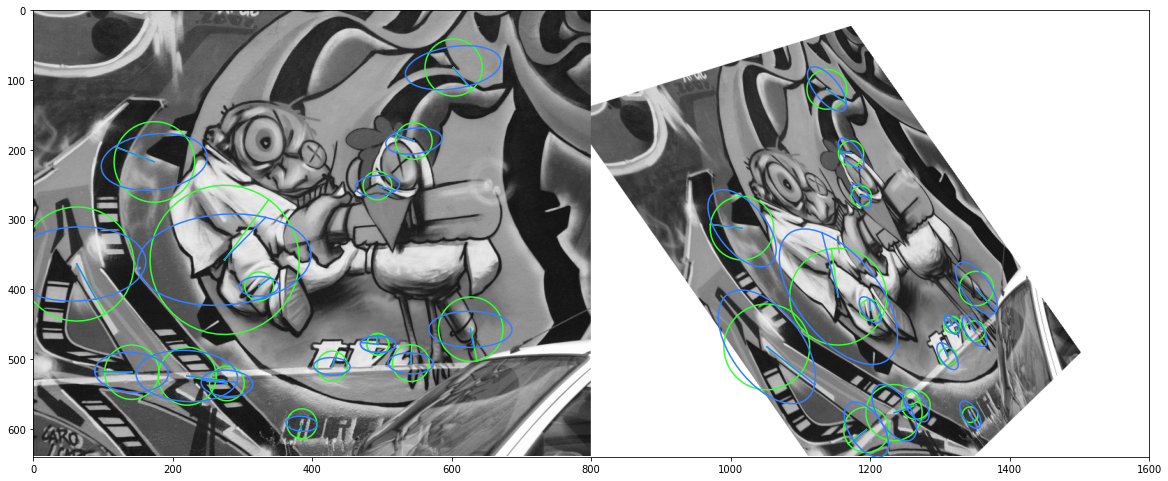

In [ ]:

det = cv2.SIFT_create(500)
img1_fname = 'data/img1.ppm'
img2_fname = 'data/img4.ppm'


img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)



Hgt = np.loadtxt('data/H1to4p')
img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))



kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)
kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)


match_dists, match_idxs = kornia.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.98)

H, mask = cv2.findHomography(kornia.feature.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             kornia.feature.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, match_idxs,
                  cv2.cvtColor(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB),
                  cv2.cvtColor(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB),
                  mask, H = H)

In [ ]:
#| export 
def draw_epipolar_errors_in_single_image(kp1: np.array, kp2: np.array,
                                         Fm1to2: np.array, img,
                                          draw_dict={"error_color": (1, 0.2, 0.2),
                                                     "feature_color": (0.2, 0.5, 1),
                                                     "figsize": (10,10),
                                                     "markersize": 8},
                                         img_index: int = 2,
                                         ax: Optional = None,
                                         title = None):
    '''This function draws epipolar errors in single image'''
    from kornia.geometry.epipolar import get_closest_point_on_epipolar_line
    img = to_numpy_image(img)
    pts1 = to_torch(kp1)[None]
    pts2 = to_torch(kp2)[None]
    Fm = to_torch(Fm1to2)
    if len(Fm.shape) == 2:
        Fm = Fm[None]
    assert img_index in [1,2]
    if img_index == 1:
        pts1, pts2 = pts2, pts1
        Fm = Fm.transpose(1, 2)
    closest_pts = get_closest_point_on_epipolar_line(pts1, pts2, Fm)
    
    # If we have no axes, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=draw_dict["figsize"])
    ax.imshow(img)
    plt.scatter(pts2[0, :, 0].numpy(),
                pts2[0, :, 1].numpy(),
                s=draw_dict["markersize"]**2,
                label='GT points',
                color = draw_dict['feature_color'])
    plt.scatter(closest_pts[0, :, 0].numpy(),
                closest_pts[0, :, 1].numpy(),
                s=draw_dict["markersize"]**2,
                label='est. projection',
                color = draw_dict['error_color'], marker='x')

    plt.plot(torch.cat([pts2[0, :, 0].view(1,-1),
                        closest_pts[0, :, 0].view(1,-1)],dim=0).numpy(),
             torch.cat([pts2[0, :, 1].view(1,-1),
                        closest_pts[0, :, 1].view(1,-1)], dim=0).numpy(),
             label='error', color=draw_dict['error_color'])

    plt.legend(['GT points','est. projection','errors'])
    if title is not None:
        plt.title(title)
    return ax

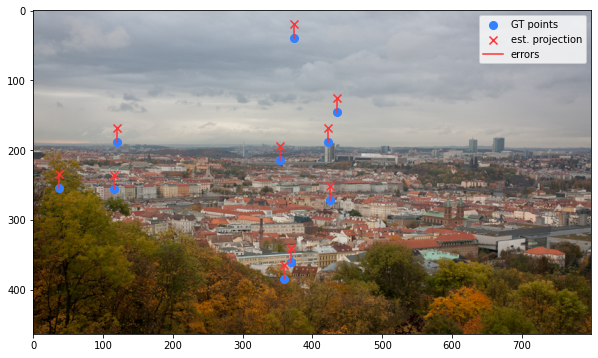

In [ ]:
kps1 = np.random.randint(0, 450, (10, 2)).astype(np.float32)
kps2 = kps1 + np.array([20., 20.]).astype(np.float32)

timg = image_to_tensor(cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB), False).float()/255.
Fm = torch.tensor([[0, 0, 0],
                  [0, 0, 1],
                  [0, -1, 0.]]).float()

ax = draw_epipolar_errors_in_single_image(kps1, kps2, Fm, timg)

In [ ]:
#| export 

def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    import matplotlib
    import matplotlib.colors as mcolors
    import matplotlib.pyplot as plt

    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2). order: [..., 0] is y, [..., 0] is x
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    import matplotlib
    import matplotlib.colors as mcolors
    import matplotlib.pyplot as plt
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2). order: [..., 0] is y, [..., 0] is x
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    import matplotlib
    import matplotlib.colors as mcolors
    import matplotlib.pyplot as plt

    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

We will visualize line segments from kornia SOLD2

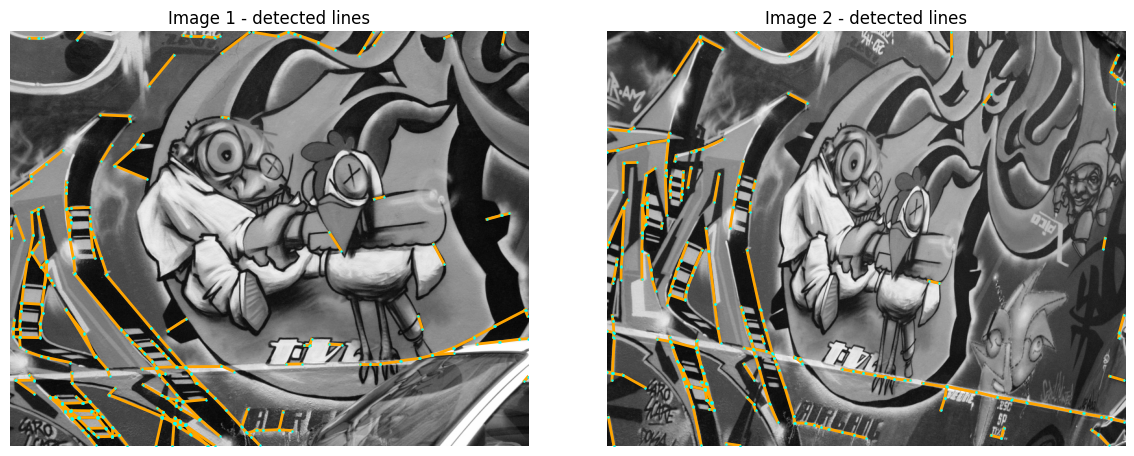

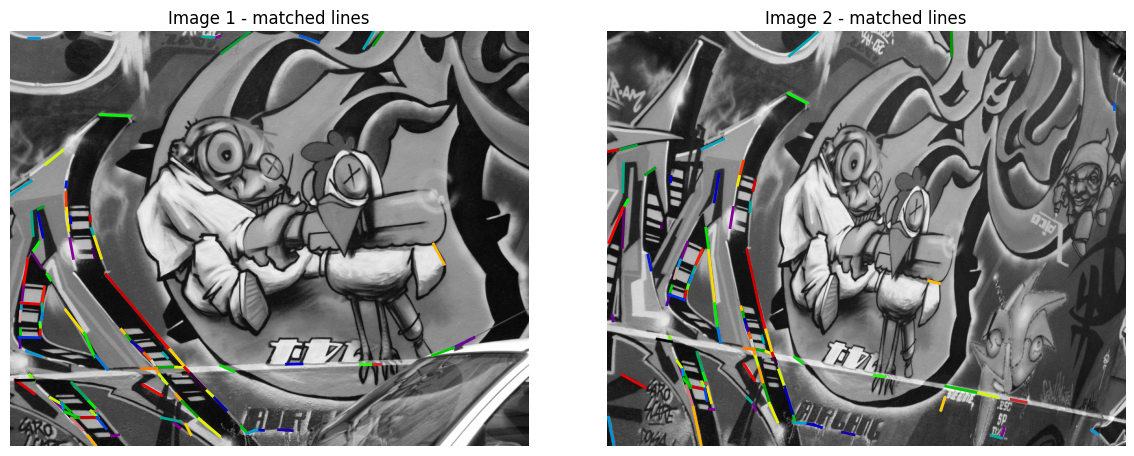

In [ ]:
timg1 = image_to_tensor(cv2.cvtColor(cv2.imread('data/img1.ppm'), cv2.COLOR_BGR2RGB), False).float()/255.
timg2 = image_to_tensor(cv2.cvtColor(cv2.imread('data/img3.ppm'), cv2.COLOR_BGR2RGB), False).float()/255.

sold2 = kornia.feature.SOLD2(pretrained=True, config=None)

timg1_gray = kornia.color.rgb_to_grayscale(timg1)
timg2_gray = kornia.color.rgb_to_grayscale(timg2)

with torch.inference_mode():
    outputs = sold2(torch.cat([timg1_gray, timg2_gray], dim=0))

line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

imgs_to_plot = [tensor_to_image(timg1_gray), tensor_to_image(timg2_gray)]

lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})


with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])

valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)


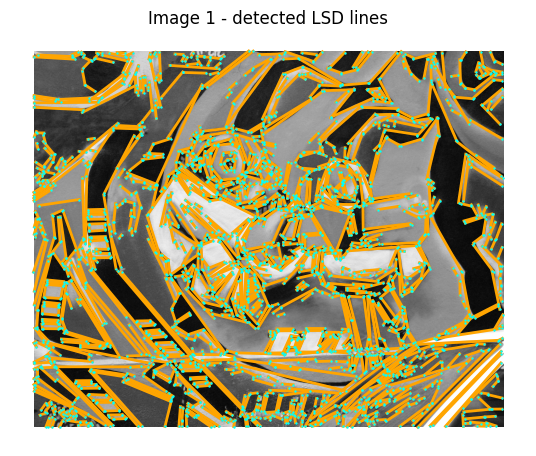

In [ ]:
import cv2

img_gray = cv2.imread('data/img1.ppm', 0)

lsd = cv2.createLineSegmentDetector(0)
lines = lsd.detect(img_gray)[0].reshape(-1, 2, 2)

lines = lines[..., ::-1]

# OpenCV LSD detector return xy order

plot_images([img_gray], ["Image 1 - detected LSD lines"])
plot_lines([lines], ps=3, lw=2, indices={0})


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()